In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web

In [4]:
# Pegando os dados
yf.pdr_override()
btc1 = web.get_data_yahoo('BTC-USD')["Close"]

[*********************100%%**********************]  1 of 1 completed


In [5]:
btc1.index = pd.to_datetime(btc1.index)
btc1 = btc1.loc['2014-09-20':'2024-03-30']

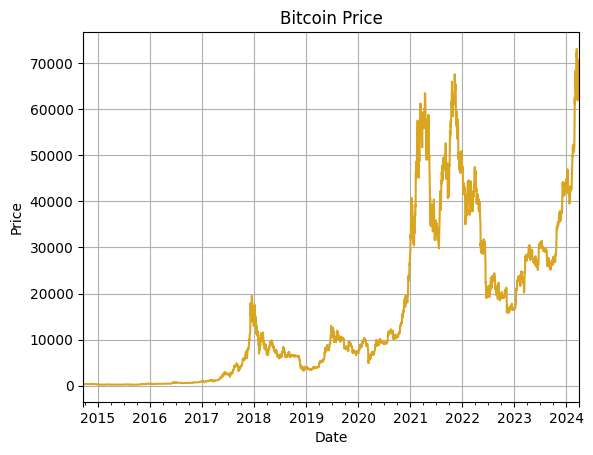

In [6]:
btc1.plot(ylabel='Price', grid=True, color='#DAA520', title='Bitcoin Price');

In [7]:
time_series = np.array(btc1)

In [8]:
# split in train test
train_serie = time_series[:-20]
test_serie = time_series[-20:]

In [9]:
len(train_serie)

3460

In [10]:
len(test_serie)

20

In [11]:
# Normalizando o treino e o test
std_norm = StandardScaler()
# TRAIN
train_serie = std_norm.fit_transform(train_serie.reshape(-1, 1))
train_serie = np.ravel(train_serie)
# TEST
test_serie = std_norm.transform(test_serie.reshape(-1, 1))
test_serie = np.ravel(test_serie)

In [12]:
train_serie[:10]

array([-0.88671981, -0.88732049, -0.88712205, -0.88511804, -0.88586784,
       -0.88656075, -0.88698664, -0.88727885, -0.88860968, -0.88871179])

In [13]:
test_serie[:10]

array([3.38563184, 3.34734855, 3.44279871, 3.34230291, 3.22358257,
       2.98000484, 3.16322524, 3.11306204, 2.77731352, 3.13481122])

In [14]:
# configurações
SEQ_LEN = 20
N_SPLITS = int(len(train_serie) / SEQ_LEN)
N_DAYS = 5

H_in = 1  # uma unica coluna de preço
H_out = 5  # 5 saidas para uma Linear
L = SEQ_LEN - N_DAYS  # Tamanho da sequencia
N_layers = 2  # numero de layers

LR = 0.01
EPOCHS = 300

In [15]:
data_train = np.array_split(train_serie, N_SPLITS)

In [16]:
data_train = np.array(data_train)

In [17]:
# Tenho 174 series com 20 dias cada
data_train.shape

(173, 20)

In [18]:
data_train

array([[-0.88671981, -0.88732049, -0.88712205, ..., -0.89105185,
        -0.89005381, -0.8893338 ],
       [-0.88954016, -0.88949626, -0.88852818, ..., -0.89005089,
        -0.88977512, -0.89108736],
       [-0.89050866, -0.89092472, -0.89167369, ..., -0.88797218,
        -0.88800041, -0.88872781],
       ...,
       [ 1.85128363,  1.64185602,  1.6412135 , ...,  1.59314983,
         1.66777538,  1.64778015],
       [ 1.62573752,  1.65511752,  1.66167579, ...,  2.16669298,
         2.19407027,  2.17361241],
       [ 2.20374081,  2.17718895,  2.14536408, ...,  3.15783192,
         3.16967459,  3.20070707]])

In [19]:
def split_X_y(data: np.array = data_train, days: int = 5) -> np.array:
    return data[:, :-days], data[:, -days:]

In [20]:
inputs, targets = split_X_y(data_train)

In [21]:
print('First Data:')
print(data_train[0])
print('First inputs:')
print(inputs[0])
print('First targets:')
print(targets[0])

First Data:
[-0.88671981 -0.88732049 -0.88712205 -0.88511804 -0.88586784 -0.88656075
 -0.88698664 -0.88727885 -0.88860968 -0.88871179 -0.88802806 -0.88822638
 -0.88873532 -0.88966229 -0.891488   -0.8919858  -0.89141573 -0.89105185
 -0.89005381 -0.8893338 ]
First inputs:
[-0.88671981 -0.88732049 -0.88712205 -0.88511804 -0.88586784 -0.88656075
 -0.88698664 -0.88727885 -0.88860968 -0.88871179 -0.88802806 -0.88822638
 -0.88873532 -0.88966229 -0.891488  ]
First targets:
[-0.8919858  -0.89141573 -0.89105185 -0.89005381 -0.8893338 ]


In [22]:
inputs = torch.tensor(inputs).to(torch.float32)
targets = torch.tensor(targets).to(torch.float32)

In [23]:
dataset = TensorDataset(inputs, targets)

In [24]:
dataloader = DataLoader(dataset, shuffle=False)

In [25]:
class BitCoinModel(nn.Module):
    def __init__(self, H_in: int = H_in, H_out: int = H_out, L: int = L, N_layers: int = N_layers):
        super(BitCoinModel, self).__init__()
        self.H_in = H_in
        self.H_out = H_out
        self.L = L
        self.N_layers = N_layers

        self.lstm = nn.LSTM(input_size=self.H_in, hidden_size=self.H_out, num_layers=self.N_layers, batch_first=True)
        self.output_layer = nn.Sequential(
            nn.Linear(self.H_out, 10),
            nn.ReLU(),
            nn.Linear(10, 5)
        )

    def forward(self, x):
        x, (ht, ct) = self.lstm(x)
        x = x[-1:, :]
        x = self.output_layer(x)
        return x

In [26]:
bitica_model = BitCoinModel()

In [27]:
optimizer = Adam(bitica_model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [28]:
loss_history = defaultdict(list)

In [29]:
optimizer.zero_grad(set_to_none=True)
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for X, y in dataloader:
        X = X.permute(1,0).to(torch.float32)
        y_hat = bitica_model(X)

        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    epoch_loss /= len(dataloader)
    loss_history['train_losses'].append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: [{epoch + 1}/{EPOCHS}] | Loss: {epoch_loss:.4f}')

Epoch: [10/300] | Loss: 0.3257
Epoch: [20/300] | Loss: 0.1874
Epoch: [30/300] | Loss: 0.0433
Epoch: [40/300] | Loss: 0.0220
Epoch: [50/300] | Loss: 0.0585
Epoch: [60/300] | Loss: 0.0363
Epoch: [70/300] | Loss: 0.0099
Epoch: [80/300] | Loss: 0.0150
Epoch: [90/300] | Loss: 0.0479
Epoch: [100/300] | Loss: 0.0109
Epoch: [110/300] | Loss: 0.0099
Epoch: [120/300] | Loss: 0.0112
Epoch: [130/300] | Loss: 0.0154
Epoch: [140/300] | Loss: 0.0067
Epoch: [150/300] | Loss: 0.0763
Epoch: [160/300] | Loss: 0.0127
Epoch: [170/300] | Loss: 0.0740
Epoch: [180/300] | Loss: 0.0113
Epoch: [190/300] | Loss: 0.0082
Epoch: [200/300] | Loss: 0.0295
Epoch: [210/300] | Loss: 0.0124
Epoch: [220/300] | Loss: 0.0087
Epoch: [230/300] | Loss: 0.0086
Epoch: [240/300] | Loss: 0.0195
Epoch: [250/300] | Loss: 0.0080
Epoch: [260/300] | Loss: 0.0092
Epoch: [270/300] | Loss: 0.0187
Epoch: [280/300] | Loss: 0.0086
Epoch: [290/300] | Loss: 0.0114
Epoch: [300/300] | Loss: 0.0408


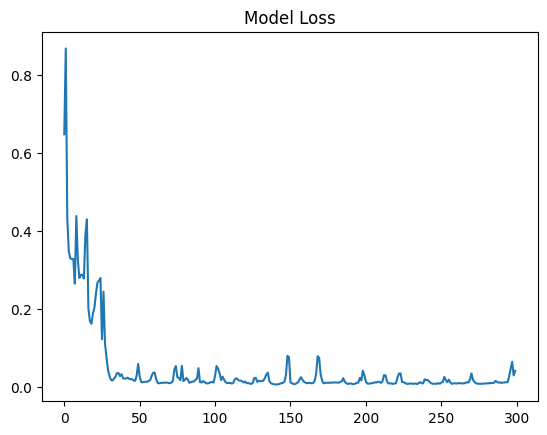

In [45]:
plt.plot(loss_history['train_losses'])
plt.title('Model Loss');

In [31]:
X_test = test_serie[:-N_DAYS]

In [32]:
y_test = test_serie[-N_DAYS:]

In [33]:
X_test = torch.tensor(X_test).to(torch.float32)
y_test = torch.tensor(y_test).to(torch.float32)

In [34]:
X_test = X_test.unsqueeze(1)

In [35]:
y_test = y_test.unsqueeze(0)

In [36]:
@torch.no_grad()
def predict(model, data):
    model.eval()
    pred = model(data)
    return pred

In [37]:
pred = predict(model=bitica_model, data=X_test)

In [38]:
y_test

tensor([[3.2584, 3.2267, 3.3035, 3.2527, 3.2380]])

In [39]:
pred

tensor([[3.1604, 3.1800, 3.2396, 3.2752, 3.2818]])

In [40]:
# agora vamos voltar aos valores originais
y_test_inverse = std_norm.inverse_transform(y_test)
y_pred_inverse = std_norm.inverse_transform(pred)

In [41]:
y_pred_inverse

array([[68343.55578699, 68672.76088016, 69672.6904848 , 70269.51703927,
        70380.77018343]])

In [42]:
y_test_inverse

array([[69987.83635658, 69455.34284619, 70744.95324271, 69892.82755619,
        69645.3044182 ]])

In [63]:
list(range(15))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [64]:
list(range(15,20))

[15, 16, 17, 18, 19]

In [62]:
 y_test_inverse.squeeze()

array([69987.83635658, 69455.34284619, 70744.95324271, 69892.82755619,
       69645.3044182 ])

In [66]:
X_test_plot = std_norm.inverse_transform(X_test.reshape(-1, 1))

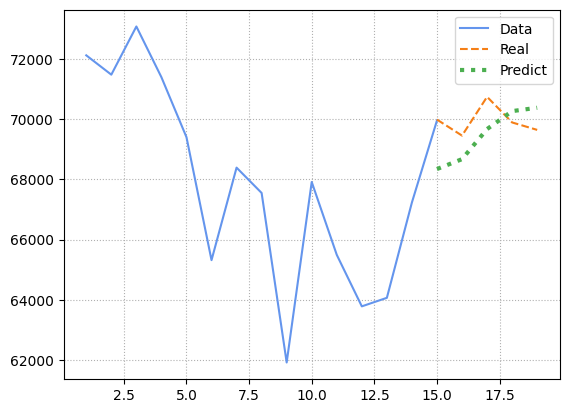

In [78]:
fig, ax = plt.subplots()
ax.plot(range(1, 16), X_test_plot, c='#6495ED', label='Data')
ax.plot(range(15,20), y_test_inverse.squeeze(), c='#F57F17', label='Real', linestyle='--')
ax.plot(range(15,20), y_pred_inverse.squeeze(), c='#4CAF50', label='Predict', linestyle=':', linewidth=3)
ax.legend()
ax.grid(True, linestyle=':')
plt.show()